In [1]:
import numpy as np

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tf_finance.price_manage import *
from tf_finance.analysis_tools import *

In [4]:
answer = PriceManager()

In [5]:
df_all = answer.daily_price()

In [6]:
df = df_all[:'2017-06-03']

In [7]:
rets = returns(df)

In [8]:
noa = df.shape[1]

In [9]:
prets, pvols = sampling_rets_vols(rets)

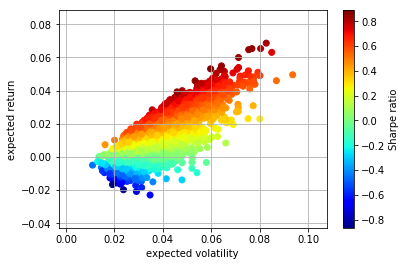

In [10]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

# 샤프 지수 최대화

In [11]:
import scipy.optimize as sco

In [31]:
opts = max_sharpe_point(rets)

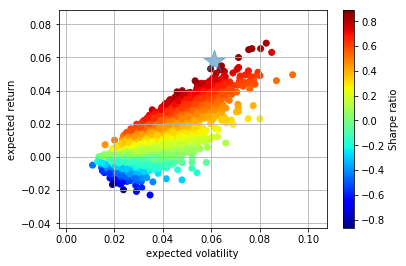

In [32]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_opts = statistics(opts, rets).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5)
plt.show()

# 포트폴리오 분산 최대화

In [30]:
optv = min_variance_point(rets)

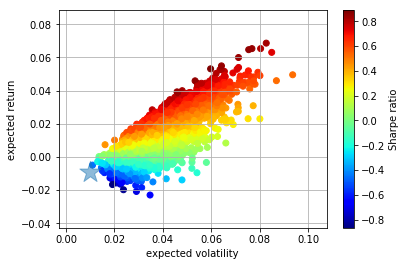

In [33]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_optv = statistics(optv, rets).round(3)
plt.scatter(pt_optv[1], pt_optv[0], marker="*", s=500, alpha=0.5)
plt.show()

# 효율적 투자선

In [25]:
bnds = tuple((0, 1) for x in range(noa))

In [26]:
statistics_rets = partial(statistics, ret_df=rets)  

In [27]:
def min_func_port(weights):
    return statistics_rets(weights)[1]

In [36]:
%%time
trets = np.linspace(0.0, 0.1, 20)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x, rets)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

Wall time: 2.14 s


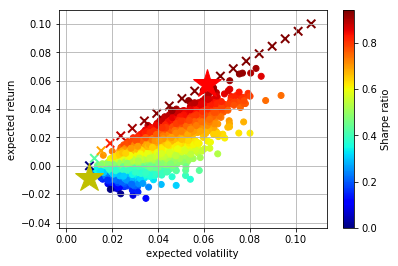

In [37]:
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o', cmap=mpl.cm.jet)
            # 무작위 포트폴리오
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x', s=70, linewidth=2, cmap=mpl.cm.jet)
            # 효율적 투자선
plt.plot(statistics(opts, rets)[1], statistics(opts, rets)[0],
         'r*', markersize=30)
            # 최대 샤프 지수를 가진 포트폴리오
plt.plot(statistics(optv, rets)[1], statistics(optv, rets)[0],
         'y*', markersize=30)
            # 최소 분산 포트폴리오
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()